## Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from matplotlib.colors import LinearSegmentedColormap

## Data Preparation

### Load Datasets

In [2]:
movies_df = pd.read_csv('../datasets/movies_metadata.csv', low_memory=False)
ratings_df = pd.read_csv('../datasets/ratings_small.csv')

### Merge Data

In [3]:
movies_df['id'] = pd.to_numeric(movies_df['id'], errors='coerce')
movies_df = movies_df.dropna(subset=['id'])

data = pd.merge(ratings_df, movies_df, left_on='movieId', right_on='id', how='inner')

## Data Preprocessing

### Feature Engineering

In [4]:
# if the movie belongs to any collection or not
data['is_in_collection'] = data['belongs_to_collection'].notnull()

# filtering out movies that were not released
data = data[data['status']=='Released']

# extracting year from the release date of the movie
data['release_year'] = pd.to_datetime(data['release_date']).dt.year

# drop irrelevant columns from the data
data = data.drop(['adult', 'belongs_to_collection', 'homepage', 'id', 'original_title', 'overview', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'spoken_languages', 'status', 'tagline', 'video'], axis=1)

### Data Preprocessing

In [5]:
# fill NULL values in Genres
data['genres'] = data['genres'].fillna('[]')
data['genres'] = data['genres'].apply(ast.literal_eval)    # string --> dictionaries

# extract names from dictionaries
data['genre_names'] = data['genres'].apply(lambda x: [d['name'] for d in x])

# One-hot Encoding
genres = data['genre_names'].str.join('|').str.get_dummies()
no_of_genres = genres.sum().sort_values(ascending=False)

data = pd.concat([data, genres], axis=1)
data = data.drop(['genres', 'genre_names'], axis=1)

## Data Visualization

In [6]:
color_palette = ['#FFF0F3', '#FFCCD5', '#FFB3C1', '#FF8FA3', '#FF758F', '#FF4D6D', '#C9184A', '#A4133C', '#800F2F', '#590D22']

cmap_reds = LinearSegmentedColormap.from_list('custom_cmap', color_palette)

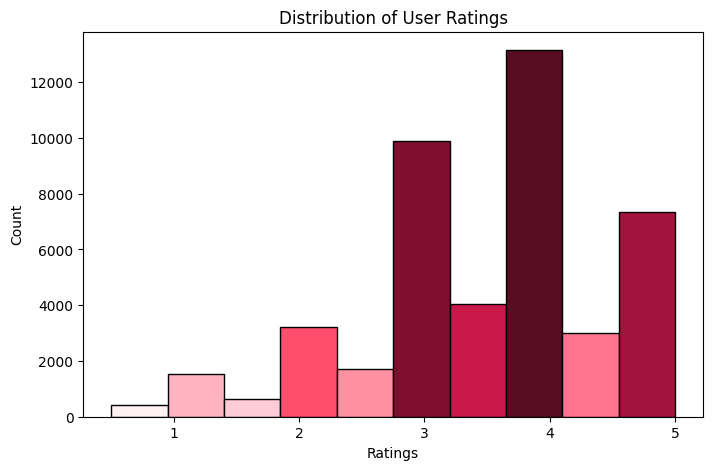

In [7]:
plt.figure(figsize=(8,5))
ax = sns.histplot(data['rating'], bins=10, kde=False)
heights = np.array([patch.get_height() for patch in ax.patches])
sorted_indices = np.argsort(heights)
for i, patch in enumerate(ax.patches):
    color_index = sorted_indices.tolist().index(i)
    patch.set_facecolor(color_palette[color_index % len(color_palette)])
plt.title('Distribution of User Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.savefig('../results/visualizations/ratings_dist.png', dpi=200)
plt.show()

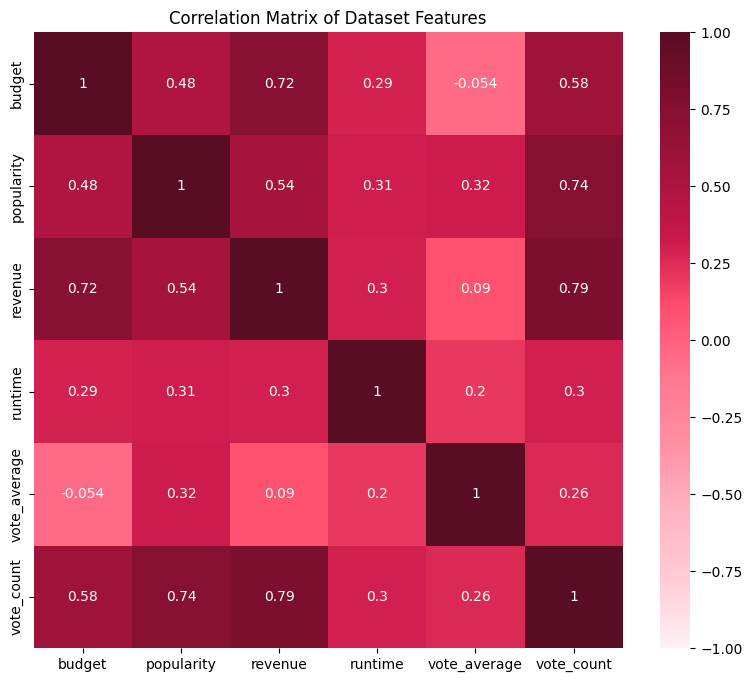

In [8]:
num_features = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
corr_matrix = data[num_features].corr()

plt.figure(figsize=(9.5,8))
sns.heatmap(corr_matrix, annot=True, cmap=cmap_reds, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Dataset Features')
plt.savefig('../results/visualizations/heatmap_features.png', dpi=125)
plt.show()

## Data Preparation 2

### Embedding or Scaling Data

In [9]:
data['movieId'] = data['movieId'].astype('int')

data['userId'] = data['userId'].astype('int')

data['rating'] = data['rating']/5.0

### Train-Test Split

In [10]:
train, test = train_test_split(data, test_size=0.2, random_state=0)

In [11]:
# 'userId' and 'movieId' will be features and 'rating' will be target for model

train_movieId = train['movieId'].values
test_movieId = test['movieId'].values

train_userId = train['userId'].values
test_userId = test['userId'].values

train_rating = train['rating'].values
test_rating = test['rating'].values

max_movieId = data['movieId'].max() + 1
max_userId = data['userId'].max() + 1

## Model Training

### Embedding

In [12]:
movie_inputs = layers.Input(shape=(1,), dtype=tf.int32, name='movie_input')
movie_embed = layers.Embedding(input_dim=max_movieId, output_dim=50)(movie_inputs)
movie_embed = layers.Flatten()(movie_embed)

user_inputs = layers.Input(shape=(1,), dtype=tf.int32, name='user_input')
user_embed = layers.Embedding(input_dim=max_userId, output_dim=50)(user_inputs)
user_embed = layers.Flatten()(user_embed)

user_movie_concat = layers.Concatenate()([user_embed, movie_embed])

In [13]:
train_userId = np.array(train_userId).reshape(-1, 1)
train_movieId = np.array(train_movieId).reshape(-1, 1)
test_userId = np.array(test_userId).reshape(-1, 1)
test_movieId = np.array(test_movieId).reshape(-1, 1)

print(train_userId.shape, train_movieId.shape, train_rating.shape)
print(test_userId.shape, test_movieId.shape, test_rating.shape)

(35951, 1) (35951, 1) (35951,)
(8988, 1) (8988, 1) (8988,)


### Build Model

In [14]:
dense = layers.Dense(256, activation='relu')(user_movie_concat)
dense = layers.BatchNormalization()(dense)
dense = layers.Dropout(0.2)(dense)
dense = layers.Dense(128, activation='relu')(dense)
dense = layers.Dense(64, activation='relu')(dense)
output = layers.Dense(1)(dense)

model = models.Model(inputs=[user_inputs, movie_inputs], outputs=output)
optimzer = Adam(learning_rate=0.001)

model.compile(optimizer=optimzer, loss='mse')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 50)     │     33,600 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │  8,035,950 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100)       │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     25,856 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,137,647 (31.04 MB)

 Trainable params: 8,137,135 (31.04 MB)

 Non-trainable params: 512 (2.00 KB)

In [15]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [16]:
history = model.fit(
    [train_userId, train_movieId],
    train_rating,
    epochs=10,                          
    batch_size=32,                     
    validation_data=([test_userId, test_movieId], test_rating),
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

model_mse = model.evaluate([test_userId, test_movieId], test_rating)
print(f'Model\'s Mean Squared Error: {model_mse}')

Epoch 1/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 78s 68ms/step - loss: 0.0756 - val_loss: 0.0373 - learning_rate: 0.0010
Epoch 2/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 75s 67ms/step - loss: 0.0340 - val_loss: 0.0356 - learning_rate: 0.0010
Epoch 3/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 74s 66ms/step - loss: 0.0297 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 4/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 74s 66ms/step - loss: 0.0272 - val_loss: 0.0341 - learning_rate: 0.0010
Epoch 5/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 74s 66ms/step - loss: 0.0257 - val_loss: 0.0344 - learning_rate: 0.0010
Epoch 6/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 74s 66ms/step - loss: 0.0233 - val_loss: 0.0359 - learning_rate: 0.0010
Epoch 7/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 75s 66ms/step - loss: 0.0216 - val_loss: 0.0366 - learning_rate: 0.0010
Epoch 8/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 74s 66ms/step - loss: 0.0172 - val_loss: 0.0372 - learning_rate: 5.0000e-04
Epoch 9/10
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 75s 66ms/step - loss: 0.0143 - val_loss: 0

## Movie Recommendation Generator

In [17]:
user_id = 1

all_movies = data['movieId'].unique()
rated_movies = data[data['userId']==user_id][['movieId', 'title', 'rating']]
unrated_movies = np.setdiff1d(all_movies, rated_movies['movieId'])

unrated_movies_inp = np.array(unrated_movies)
user_input_list = np.full(len(unrated_movies_inp), user_id)

In [18]:
ratings_prediction = model.predict([user_input_list, unrated_movies_inp])

movies_prediction = pd.DataFrame({
    'movieId': unrated_movies_inp,
    'rating_prediction': ratings_prediction.flatten()
})

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [21]:
recommendations = movies_prediction.sort_values(by='rating_prediction',ascending=False).head(15)
recommendations = pd.merge(recommendations, movies_df[['id', 'title']], left_on='movieId', right_on='id')
recommendations['rating_prediction'] = (recommendations['rating_prediction']*10).round(1)

print(f'Top Movie Recommendations for User {user_id}:')
print(recommendations[['title', 'rating_prediction']])

Top Movie Recommendations for User 1:
                           title  rating_prediction
0        The Talented Mr. Ripley                9.7
1               Kindergarten Cop                9.5
2                    42nd Street                9.2
3           Sleepless in Seattle                9.1
4                     Blindsight                8.7
5                          Dread                8.6
6                     Straw Dogs                8.6
7               Dawn of the Dead                8.5
8                The Sixth Sense                8.5
9   The Howling: New Moon Rising                8.5
10                 Before Sunset                8.4
11        Lotte from Gadgetville                8.4
12            Young and Innocent                8.3
13        Mission: Impossible II                8.3
14      Vicky Cristina Barcelona                8.3
